In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import xarray as xr
import seaborn as sns
import cmlreaders as cml
import cmldask.CMLDask as da
from random import sample
import os
import glob
import pickle
import traceback
import numpy as np
import cmlreaders as cml
import pandas as pd
import mne
import matplotlib.pyplot as plt
import math
from mne.time_frequency import tfr_morlet
from ptsa.data.filters import ResampleFilter, ButterworthFilter, MorletWaveletFilter
from ptsa.data.timeseries import TimeSeries
from pandas import MultiIndex

In [3]:
#Define experiment
exp = 'ltpDelayRepFRReadOnly'
df = cml.get_data_index()
df = df[df['experiment']==exp]
subjs = np.unique(df['subject'])
subjs = subjs[:-1]
ix = cml.get_data_index()
exp_ix = ix.query('experiment == @exp')

#Define ROI
biosem_Ch = ['A5', 'A6', 'A7', 'A8', 'A9', 'A10','A15', 'A16', 'A17', 'A18',
             'A28', 'A29', 'A30', 'A31', 'A32',
   'B3', 'B4', 'B5', 'B6', 'B7', 'B11', 'B12', 'B13', 'B30', 'B31',
   'B32', 'C2', 'C3', 'C4', 'C11', 'C12', 'C13',
   'C24', 'C25', 'C26', 'D2', 'D3', 'D4', 'D9',
   'D10', 'D11', 'D12', 'D13', 'D29', 'D30', 'D31']



## 1. Get Features

We first need to get the neural feautures from EEG recorded during each word encoding event, and just prior to each recall event. For each electrode, we will compute power at 8 logarithmically spaced frequencies between 3 and 180 Hz. Power will then be Z-scored across all timepoints across all recall and encoding events. 

For encoding events, we will examine the period from 1600 to 4100 ms post-stimulus. For recall, we will examine the time points from -900 to -200 ms prior to the onset of the retrieval. Following the method used by Katerman et al. (2022), recall events will be excluded if they occur within 1000 ms after a prior retrieval. 

In [4]:
#Compute spectral wavelets 
def compute_features(row, 
                     settings_path='/home1/adamwb/RepFR_RSA_Analysis/RepFR_test_encoding.pkl', 
                     save_path='/home1/adamwb/RepFR_RSA_Analysis/RSA_features_wholetrial',
                     overwrite=False):
    """
    Compute log-transformed powers, averaged over time and stacked as (frequency, channel) to create features
    These can later be normalized along the event axis.
    """
    settings = da.Settings.Load(settings_path)
    df = cml.get_data_index()
    #sub_ix = ix.query('experiment == @settings.experiment and subject == @subject')
    ev_type = settings.type
    save_fp = save_path + '/' + row.subject + '_' + str(row.session) + '_' + settings.type + '.pkl'
    print(save_fp)
    if (not os.path.exists(save_fp)) or overwrite:
        print("Reading subject:", row.subject, "session:", row.session)
        # intialize data reader, load words events and buffered eeg epochs
        
        df_select = exp_ix[exp_ix['subject']==row.subject]
        df_sess = df_select.iloc[np.where(np.array(df_select['session']) == row.session)[0][0]]

        r = cml.CMLReader(subject=df_sess.subject,
                          session=df_sess.session,
                          experiment=df_sess.experiment)
        
        # r = cml.CMLReader(subject=row.subject, 
        #                   experiment=row.experiment, session=row.session,
        #                   localization=row.localization, montage=row.montage)
        
        evs = r.load('task_events')
        evs = evs.query('type == @settings.type and eegoffset != -1')
        print(evs)
        if settings.type == "REC_WORD":
            # get inter-retreival times since previous recall
            evs['pirt'] = evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
            evs['repeat'] = evs.duplicated(subset=['session', 'list', 'item_name'])
            evs['outpos'] = evs.groupby(['subject', 'session', 'list']).cumcount()
            # only include recalls at least 1000 ms away and no repeats
            evs = evs.query('pirt > 1000 and repeat == 0')
            


            eeg = r.load_eeg(evs, 
                             clean = True,
                             rel_start=settings.rel_start, 
                             rel_stop=settings.rel_stop).to_ptsa()
            

        else:
            eeg = r.load_eeg(events=evs,
                             clean = True,
                             rel_start=settings.rel_start - settings.buffer_time,
                             rel_stop=settings.buffer_time+settings.rel_stop).to_ptsa()
        
        # select relevant channels
        #Ch = eeg.channel[biosem_Ch]
        eeg = eeg.sel(channel = biosem_Ch)

        eeg['time'] = eeg['time'] / 1000 # PTSA time scale is in seconds instead of ms
        eeg = eeg.add_mirror_buffer(settings.buffer_time/1000)
        eeg['time'] = eeg['time'] * 1000
        # centering signal within event
        # reduce edge effects / ringing in later processing steps:
        eeg = eeg.astype(float) - eeg.mean('time')
        # filter out line noise at 60 Hz
        eeg = ButterworthFilter(filt_type='stop', 
                                freq_range=[58, 62], 
                                order=4).filter(timeseries=eeg)
        eeg = ResampleFilter(resamplerate=500).filter(
            timeseries=eeg)
        
        pows = [[]]*len(eeg)
        for i in range(len(pows)):
            pwr = MorletWaveletFilter(freqs=settings.freqs,
                                           width=5,
                                           output='power',
                                           cpus=4).filter(timeseries=eeg[i])
            pwr = ResampleFilter(resamplerate=16).filter(
                    timeseries=pwr)
            pows[i] = pwr.remove_buffer(settings.buffer_time / 1000).data
        pows = np.array(pows)

        del eeg

        pows = pows.mean(3) #average over time
        
        pows = np.reshape(pows, (len(pows), (len(pows[0][0]) * len(settings.freqs))))
        
        pows = np.log10(pows) #Log transform powers
        
        #save out powers
        with open(save_fp, 'wb') as f:
            pickle.dump(pows, f)
        return pows
    

Now we create separate configuration files to get features for encoding and retrieval

In [6]:
#Settings for encoding events
settings = da.Settings()
settings.width = 5
settings.rel_start = 1600
settings.rel_stop = 4100
settings.experiment = 'ltpDelayRepFRReadOnly'
settings.freqs = np.logspace(np.log10(2),np.log10(100), 46)
settings.type = 'WORD'
settings.buffer_time = 600
settings.resameplerate = 500
settings.Save("RepFR_encoding_preprocess.pkl")


In [128]:
client = da.new_dask_client("RepFR_encoding_preprocessing",
                            "22GB",
                            max_n_jobs=50,
                            log_directory='/home1/adamwb/RepFR_RSA_Analysis/log_directory')

Unique port for adamwb is 51268
{'dashboard_address': ':51268'}
To view the dashboard, run: 
`ssh -fN adamwb@rhino2.psych.upenn.edu -L 8000:192.168.86.106:51268` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


In [131]:
futures = client.map(
    compute_features, 
    list(exp_ix.itertuples()), 
    overwrite=True,
    settings_path='/home1/adamwb/RepFR_RSA_Analysis/RepFR_encoding_preprocess.pkl',
    save_path='/home1/adamwb/RepFR_RSA_Analysis/RSA_features_wholetrial')


In [46]:
client.shutdown()

2024-08-21 11:43:47,100 - distributed.deploy.adaptive_core - INFO - Adaptive stop


In [473]:
#Settings for recall events
settings = da.Settings()
# freqs = np.unique(np.round(np.logspace(np.log10(1), np.log10(300), 17)))
settings.freqs = np.logspace(np.log10(2),np.log10(100), 46)
settings.width = 5
settings.experiment = 'ltpDelayRepFRReadOnly'
settings.resameplerate = 500
settings.type = 'REC_WORD'
settings.rel_start = -900
settings.rel_stop = -200
settings.buffer_time = 600
settings.Save("RepFR_retrieval_preprocess.pkl")

In [474]:
client_2 = da.new_dask_client("RepFR_retrieval_preprocessing",
                            "24GB",
                            max_n_jobs=70,
                            log_directory='/home1/adamwb/RepFR_RSA_Analysis/log_directory')

Unique port for adamwb is 51268
{'dashboard_address': ':51268'}
To view the dashboard, run: 
`ssh -fN adamwb@rhino2.psych.upenn.edu -L 8000:192.168.86.145:41626` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


/home1/adamwb/.conda/envs/adam_cml/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 51268 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41626 instead
  warnings.warn(


In [475]:
futures = client_2.map(
    compute_features, 
    list(exp_ix.itertuples()), 
    overwrite=True,
    settings_path='/home1/adamwb/RepFR_RSA_Analysis/RepFR_retrieval_preprocess.pkl',
    save_path='/home1/adamwb/RepFR_RSA_Analysis/RSA_Features')

In [57]:
allsix = 0
for el in np.unique(runSubj):
    if sum(np.array(runSubj) == el) > 2:
        allsix = allsix + 1
        

In [6]:
#Check subjects with successfully computed features
import os
runSubj = os.listdir('/home1/adamwb/RepFR_RSA_Analysis/RSA_matrices/')
runSubj = [el[:6] for el in runSubj]
runSubj = np.unique(runSubj)
runSubj = runSubj[1:]
runSubj
    

array(['LTP501', 'LTP502', 'LTP503', 'LTP504', 'LTP505', 'LTP507',
       'LTP508', 'LTP509', 'LTP510', 'LTP511', 'LTP513', 'LTP514',
       'LTP515', 'LTP516', 'LTP518', 'LTP519', 'LTP520', 'LTP521',
       'LTP522', 'LTP524', 'LTP525', 'LTP527', 'LTP528', 'LTP530',
       'LTP531', 'LTP533', 'LTP534', 'LTP535', 'LTP536', 'LTP537',
       'LTP538', 'LTP540', 'LTP541', 'LTP542', 'LTP543', 'LTP544',
       'LTP545', 'LTP546', 'LTP547', 'LTP549', 'LTP550', 'LTP551',
       'LTP552', 'LTP553', 'LTP554', 'LTP555', 'LTP557', 'LTP558',
       'LTP559', 'LTP561', 'LTP562', 'LTP563'], dtype='<U6')

All 52 participants have been run successfully

# 3. Peform RSA Using Jeremy Manning and Lynn Lohnas Methods

You can just perform RSA on the raw EEG features, but Manning et al (2011) and Lohnas et al (2023) performed PCA on the features, selected the components with a significant level of explained various, identified and selected the autocorrelated components, and then did the RSA using those. Here we replicate their methods.

In [7]:
from sklearn.decomposition import PCA
from scipy.stats import pearsonr, norm
import math

#https://www.mathworks.com/matlabcentral/fileexchange/62633-princom-x-econflag?s_tid=srchtitle
# #     % Enforce a sign convention on the coefficients -- the largest element in each  
# #     % column will have a positive sign. 
def sign_convention(coeff, score):
    # [~, maxind] = max(abs(coeff),[],1);  
    maxind = np.argmax(abs(coeff), axis=0)
    # d = size(coeff,2);  

    # colsign = sign(coeff(maxind + (0:p:(d-1)*p)));  
    colsign = np.sign(np.take_along_axis(coeff, np.expand_dims(maxind, axis=0), axis=0).squeeze(axis=0))
    # coeff = bsxfun(@times,coeff,colsign);  
    coeff = coeff * colsign
    # score = bsxfun(@times,score,colsign); 
    score = score * colsign
    return coeff, score

def princomp(encoding_pows, rec_pows):
    
    #Train on encoding features
    pca = PCA()
    pca.fit(encoding_pows)
    latent = pca.explained_variance_
    coeff = pca.components_.T
    
    #Fit features to encoding and retrieval data
    enc_pcs = pca.transform(encoding_pows) # names like MATLAB
    rec_pcs = pca.transform(rec_pows)
    
    coeff, score = sign_convention(coeff, enc_pcs)
    
    #Select components with explained variance > 1
    enc_pcs = enc_pcs[:, pca.explained_variance_ > 1]
    rec_pcs = rec_pcs[:, pca.explained_variance_ > 1]
    
    
    
    return enc_pcs, rec_pcs


def select_autocorrelated_features(enc_pcs, rec_pcs, is_repeat):
    
    listlength = 18
    nLists = 21

    #Create indices for each list
    lists = np.array([])
    for i in range(0, nLists):
        templist = [i]*listlength
        lists = np.append(lists, templist)
    
    # Get pearson correlation and p_val by list for for each component
    rMat = np.array([[np.nan]*nLists]*len(enc_pcs[0]))
    pMat = np.array([[np.nan]*nLists]*len(enc_pcs[0]))
    for i in range(0,nLists):
        for t in range(len(enc_pcs[0])):
            listind = np.where(lists == i)[0]
            temp = np.array([])
            for ind in listind:
                temp = np.append(temp, enc_pcs[ind][t])

            r, p =  pearsonr(temp[:-1], temp[1:])
            rMat[t][i] = r
            pMat[t][i] = p
    
    #Get r and p_val summary statistics for each component
    r_combi = np.array([])
    p_combi = np.array([])
    for i in range(len(rMat)):
        Ztrans_r = .5*(np.log(1 + rMat[i])) - np.log(1 - rMat[i])
        r_combi = np.append(r_combi, (math.exp(2*sum(Ztrans_r))-1)/(math.exp(2*sum(Ztrans_r))+1))
        
        p_combi = np.append(p_combi, norm.cdf(sum(norm.ppf(pMat[i]))))
    
    
    #Select good components
    keepinds = np.array([False]*len(rMat))
    keepinds[(r_combi > 0) & (p_combi < .1)] = True
    
    #Filter encoding and retrieval pc's
    enc_select = [[]]*len(enc_pcs)
    for i in range(len(enc_pcs)):
        enc_select[i] = enc_pcs[i][keepinds]
    
    rec_select = [[]]*len(rec_pcs)
    for i in range(len(rec_pcs)):
        rec_select[i] = rec_pcs[i][keepinds]
        
    return np.array(enc_select), np.array(rec_select)
    

Now we construct a wrapper function to run the PCA and component selection for encoding and retrieval data.

In [133]:
load_path1='/home1/adamwb/RepFR_RSA_Analysis/RSA_features_wholetrial' 
load_path2='/home1/adamwb/RepFR_RSA_Analysis/RSA_Features' 

def PCA_wrapper(subj, sess):
    
    save_path =  '/home1/adamwb/RepFR_RSA_Analysis/RSA_features_wholetrial_selected/'
    encoding_fp = load_path1 + '/' + str(subj) + '_' + str(sess)[0] + '_WORD.pkl'
    retrieval_fp = load_path2 + '/' + str(subj) + '_' + str(sess)[0] + '_REC_WORD.pkl'
    
    df_select = exp_ix[exp_ix['subject']==subj]
    df_sess = df_select.iloc[np.where(np.array(df_select['session']) == sess)[0][0]]

    r = cml.CMLReader(subject=df_sess.subject,
                      session=df_sess.session,
                      experiment=df_sess.experiment)

    word_type = 'WORD'
    rec_type = 'REC_WORD'
    evs = r.load('task_events')
    enc_evs = evs.query('type == @word_type and eegoffset != -1')
    is_repeat = np.array(enc_evs.is_repeat)


    with open(encoding_fp, "rb") as f:
        encoding_pows = pickle.load(f)

    enc_pows = sp.stats.zscore(encoding_pows)

    with open(retrieval_fp, "rb") as f:
        rec_pows = pickle.load(f)
    rec_pows = sp.stats.zscore(rec_pows)
    
    #Make sure all encoding events present
    if len(enc_pows) < 378:
        print('Not enough encoding events: ', str(subj), "session:", str(sess)[0])
        return
        
    
    #Perform PCA and select components
    try:
        enc_pcs, rec_pcs = princomp(enc_pows, rec_pows)
        enc_select, rec_select = select_autocorrelated_features(enc_pcs, rec_pcs, is_repeat)
    except (FileNotFoundError, RuntimeError, TypeError, NameError, ValueError, AssertionError, IndexError):
        print("Error! Subject " + str(subj) + " Session " + str(sess))
        return
    
    #Check to see there are at least 5 autocorrelated features
    if len(enc_select[0]) < 5:
        print('Not enough good features: ', str(subj), "session:", str(sess)[0])
        return
    
    Encfp = save_path + str(subj) + '_' + str(sess)[0] + '_WORD_924.pkl'
    Recfp = save_path + str(subj) + '_' + str(sess)[0] + '_REC_WORD_924.pkl'
    with open(Encfp, 'wb') as f:
        pickle.dump(enc_select, f)
    with open(Recfp, 'wb') as f:
        pickle.dump(rec_select, f)



In [134]:
#Run the PCA wrapper
for subj in runSubj:
    subDir =  glob.glob('/home1/adamwb/RepFR_RSA_Analysis/RSA_features_wholetrial/' + str(subj) + '*_WORD.pkl')
    sessions = []
    for el in subDir:
        sessions = np.append(sessions, int(el[-10]))
        
        
    for sess in sessions:
        PCA_wrapper(subj, sess)
    
    

Error! Subject LTP503 Session 5.0
Not enough encoding events:  LTP503 session: 4
Error! Subject LTP504 Session 2.0
Not enough encoding events:  LTP505 session: 5
Not enough encoding events:  LTP505 session: 1
Error! Subject LTP510 Session 4.0
Not enough encoding events:  LTP514 session: 0
Not enough encoding events:  LTP515 session: 2
Not enough encoding events:  LTP516 session: 3
Not enough encoding events:  LTP521 session: 2
Not enough encoding events:  LTP522 session: 5
Error! Subject LTP535 Session 2.0
Not enough encoding events:  LTP540 session: 1
Not enough encoding events:  LTP541 session: 3
Not enough encoding events:  LTP561 session: 5


Now that we have our selected neural features, we can compute PCA between encoding and retrieval

In [136]:
# Compute RSA on selected PCs
def compute_rsa_PCA(subj, sess, 
                save_path='/home1/adamwb/RepFR_RSA_Analysis/RSA_matrices_wholetrial',
                load_path='/home1/adamwb/RepFR_RSA_Analysis/RSA_features_wholetrial_selected' ):
    """
    Compute rsa between two periods.
    """

    print("Processing subject:", str(subj), "session:", str(sess)[0])
    save_fp = save_path + '/' + str(subj) + '_' + str(sess)[0] + '_rsa_wholetrial.pkl'
    #if (not os.path.exists(save_fp)):
        # intialize data reader, load words events and buffered eeg epochs
    encoding_fp = load_path + '/' + str(subj) + '_' + str(sess)[0] + '_WORD_924.pkl'
    retrieval_fp = load_path + '/' + str(subj) + '_' + str(sess)[0] + '_REC_WORD_924.pkl'


    with open(encoding_fp, "rb") as f:
        encoding_pcs = pickle.load(f)


    with open(retrieval_fp, "rb") as f:
        rec_pcs = pickle.load(f)



    #Make RSA matrix that is nRecalls x nEncoding events long
    RSAs = [[]] * len(rec_pcs)       
    for i in range(len(rec_pcs)):
        for j in range(len(encoding_pcs)):
            RSAs[i] = np.append(RSAs[i], np.corrcoef(rec_pcs[i], encoding_pcs[j])[0][1])

    with open(save_fp, 'wb') as f:
        pickle.dump(RSAs, f)
    return RSAs
                

In [141]:
for subj in runSubj:
    subDir =  glob.glob('/home1/adamwb/RepFR_RSA_Analysis/RSA_features_wholetrial_selected/' + str(subj) + '*REC_WORD_924.pkl')
    sessions = []
    for el in subDir:
        sessions = np.append(sessions, int(el[-18]))
        
    for sess in sessions:
         compute_rsa_PCA(subj, sess)

Processing subject: LTP501 session: 3
Processing subject: LTP501 session: 1
Processing subject: LTP501 session: 5
Processing subject: LTP501 session: 2
Processing subject: LTP501 session: 4
Processing subject: LTP501 session: 0
Processing subject: LTP502 session: 5
Processing subject: LTP502 session: 3
Processing subject: LTP502 session: 1
Processing subject: LTP502 session: 0
Processing subject: LTP502 session: 2
Processing subject: LTP502 session: 4
Processing subject: LTP503 session: 1
Processing subject: LTP503 session: 3
Processing subject: LTP503 session: 0
Processing subject: LTP503 session: 2
Processing subject: LTP504 session: 1
Processing subject: LTP504 session: 5
Processing subject: LTP504 session: 3
Processing subject: LTP504 session: 0
Processing subject: LTP504 session: 4
Processing subject: LTP505 session: 4
Processing subject: LTP505 session: 0
Processing subject: LTP507 session: 3
Processing subject: LTP507 session: 1
Processing subject: LTP507 session: 5
Processing s

With our RSA matrices computed, we can now compare neural similarity between retrieval and the first and second instance of each of the item's presentations. Here we examine Lags -5 to +5 for each encoding event.

In [8]:

def compare_RSAs(subj, sess, RSAfile):
    RSA_data = [['Subject'], ['Session'], ['Pres_Num'], ['Lag'], ['ERS']]
    data_path = '/home1/adamwb/RepFR_RSA_Analysis/RSA_linmods/'
    
    df_select = exp_ix[exp_ix['subject']==subj]
    df_sess = df_select.iloc[np.where(np.array(df_select['session']) == sess)[0][0]]

    r = cml.CMLReader(subject=df_sess.subject,
                      session=df_sess.session,
                      experiment=df_sess.experiment)

    word_type = 'WORD'
    rec_type = 'REC_WORD'
    evs = r.load('task_events')
    enc_evs = evs.query('type == @word_type and eegoffset != -1')
    rec_evs = evs.query('type == @rec_type and eegoffset != -1')

    rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
    rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
    rec_evs['outpos'] = rec_evs.groupby(['subject', 'session', 'list']).cumcount()
    # only include recalls at least 1000 ms away and no repeats
    rec_evs = rec_evs.query('pirt > 1000 and repeat == 0')
    
    output_num = []
    List = np.array(rec_evs.list)
    for i in np.unique(List):
        outputs = range(0, sum(List == i))
        output_num = np.append(output_num, outputs)

    #Load RSA matrix

    with open(RSAfile, 'rb') as f:
        RSAs = pickle.load(f)

    RSAs = np.array(RSAs)    
    enc_items = np.array(enc_evs.item_num)
    rec_items = np.array(rec_evs.item_num)
    rec_repeats = np.array(rec_evs.repeats)
    enc_SP = np.array(enc_evs.serialpos)
    
    #Check if dimensions match between RSAs, encoding and retrieval matrices

    RSA_firstpres = []
    RSA_secondpres = []
    same_item_order = 0

    for i in range(len(rec_repeats)):
        RSA_temp = RSAs[rec_items == rec_items[i]][0]
        
        #Check for intrusion
        if np.in1d(rec_items[i], enc_items) == False:
            continue
            
        #Exclude first output during recall period
        if output_num[i] == 0:
            continue
            
        if rec_repeats[i] == 2 and len(np.where(enc_items == rec_items[i])[0]) > 1: #Checking if repeat
            enc_ind = np.where(enc_items == rec_items[i])[0] # First and second indices of item presentaiton
            
            if np.where(enc_items == rec_items[i])[0][1] < 377:
                if enc_items[np.where(enc_items == rec_items[i])[0][0] + 1] == enc_items[np.where(enc_items == rec_items[i])[0][1] + 1]:
                    same_item_order = same_item_order + 1
                    continue

                if enc_items[np.where(enc_items == rec_items[i])[0][0] -1] == enc_items[np.where(enc_items == rec_items[i])[0][1] + 1]:
                    same_item_order = same_item_order + 1
                    continue


            if (enc_SP[enc_ind[0]] > 4) and (enc_SP[enc_ind[0]] < 13):
                RSA_firstpres.append(RSA_temp[enc_ind[0] - 5:enc_ind[0] + 6])

            if enc_SP[enc_ind[0]] < 5:
                # continue # skip early SPs
                temp = [np.nan]*(5 - enc_SP[enc_ind[0]])
                temp = np.append(temp, RSA_temp[enc_ind[0] - enc_SP[enc_ind[0]]:enc_ind[0] + 6])
                RSA_firstpres.append(temp)

            if enc_SP[enc_ind[0]] > 12:
                temp = [np.nan]*(5 - (17 - enc_SP[enc_ind[0]]))
                temp = np.append(RSA_temp[enc_ind[0] - 5:enc_ind[0] +  (18 - enc_SP[enc_ind[0]])], temp)
                RSA_secondpres.append(temp)                            
            if enc_ind[1] - enc_ind[0] < 6:
                RSA_firstpres[len(RSA_firstpres) - 1][6:] = np.nan

            #Second presentation
            if (enc_SP[enc_ind[1]] > 4) and (enc_SP[enc_ind[1]] < 13):
                RSA_secondpres.append(RSA_temp[enc_ind[1] - 5:enc_ind[1] + 6])


            if enc_SP[enc_ind[1]] > 12:
                # continue # skip late SPs
                temp = [np.nan]*(5 - (17 - enc_SP[enc_ind[1]]))
                temp = np.append(RSA_temp[enc_ind[1] - 5:enc_ind[1] +  (18 - enc_SP[enc_ind[1]])], temp)
                RSA_secondpres.append(temp)                            
            if enc_ind[1] - enc_ind[0] < 6:
                RSA_secondpres[len(RSA_secondpres) - 1][:5] = np.nan


    

    

    RSA_firstpres = np.nanmean(RSA_firstpres, axis = 0)
    RSA_secondpres = np.nanmean(RSA_secondpres, axis = 0)

    

    print('num same order = '+ str(same_item_order)) #Number of times a sequence of the same two items repeats within a list
    
    return RSA_firstpres, RSA_secondpres


In [59]:
# Compare RSAs for each condition
RSA_first = [[]]*len(runSubj)
RSA_second = [[]]*len(runSubj)

RSA_data = [['Subject'], ['Pres_Num'], ['Lag'], ['ERS']]
linPath = '/home1/adamwb/RepFR_RSA_Analysis/Linmod_RSA.txt'
for i in range(len(runSubj)):
    subj = runSubj[i]
    subDir =  glob.glob('/home1/adamwb/RepFR_RSA_Analysis/RSA_matrices_PCA/' + str(runSubj[i]) + '*rsa_postenc.pkl')
    RSA_firstpres = [[]]*len(subDir)
    RSA_secondpres = [[]]*len(subDir)
    for k in range(len(subDir)):
        RSAfile = subDir[k]
        sess = int(subDir[k][-17])
        RSA_firstpres[k], RSA_secondpres[k] = compare_RSAs(subj, sess, RSAfile)        
    RSA_secondpres = [ele for ele in RSA_secondpres if ele != []]  
    
    RSA_first[i] = np.nanmean(RSA_firstpres, axis = 0)
    RSA_second[i] = np.nanmean(RSA_secondpres, axis = 0)

    

RSA_first = [ele for ele in RSA_first if ele != []]
RSA_second = [ele for ele in RSA_second if ele != []]  

for i in range(0, 11):
    for k in range(len(RSA_first)):
        RSA_data.append([
            runSubj[k],
            'first',
            abs(i - 5),
            RSA_first[k][i]])
    for k in range(len(RSA_second)):
        RSA_data.append([
            runSubj[k],
            'second',
            abs(i - 5),
            RSA_second[k][i]])

file = open(linPath, 'w')
for line in  RSA_data:
    line_str = ''
    for element in line:
        line_str += str(element) + '\t'
    file.write(line_str + '\n')
file.close()

/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 29
num same order = 20
num same order = 19


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 24
num same order = 26
num same order = 27


/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['outpos'] = rec_evs.groupby(['subject', 'session', 'list']).cumcount()
/tmp/ipykernel_86205/197901396.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  RSA_secondpres = [ele for ele in RSA_secondpres if ele != []]
/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff

num same order = 20
num same order = 20
num same order = 18


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 19
num same order = 25
num same order = 12


/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['outpos'] = rec_evs.groupby(['subject', 'session', 'list']).cumcount()
/tmp/ipykernel_86205/197901396.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  RSA_secondpres = [ele for ele in RSA_secondpres if e

num same order = 13
num same order = 11
num same order = 14
num same order = 19


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 17
num same order = 9
num same order = 3
num same order = 6


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 10
num same order = 8
num same order = 8
num same order = 12


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 30
num same order = 7
num same order = 5
num same order = 11


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 8
num same order = 9
num same order = 12
num same order = 19


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 21
num same order = 20
num same order = 22


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 21
num same order = 28
num same order = 21


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 15
num same order = 19
num same order = 17


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 24
num same order = 15
num same order = 10
num same order = 22


/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['outpos'] = rec_evs.groupby(['subject', 'session', 'list']).cumcount()
/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

num same order = 21
num same order = 17
num same order = 16
num same order = 14


/tmp/ipykernel_86205/197901396.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  RSA_secondpres = [ele for ele in RSA_secondpres if ele != []]
/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['sessi

num same order = 10
num same order = 10
num same order = 14
num same order = 13


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 19
num same order = 20
num same order = 21


/tmp/ipykernel_86205/197901396.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  RSA_secondpres = [ele for ele in RSA_secondpres if ele != []]
/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['sessi

num same order = 23
num same order = 25
num same order = 26


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 12
num same order = 10
num same order = 17
num same order = 13


/tmp/ipykernel_86205/197901396.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  RSA_secondpres = [ele for ele in RSA_secondpres if ele != []]
/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['sessi

num same order = 19
num same order = 22
num same order = 21


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 29
num same order = 22
num same order = 2
num same order = 1


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 10
num same order = 13
num same order = 3
num same order = 10
num same order = 10


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 6
num same order = 9
num same order = 6
num same order = 9
num same order = 14


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 18
num same order = 17
num same order = 21
num same order = 13


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 19
num same order = 18
num same order = 25


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 16
num same order = 16
num same order = 14


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 19
num same order = 22
num same order = 11


/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['outpos'] = rec_evs.groupby(['subject', 'session', 'list']).cumcount()
/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

num same order = 17
num same order = 24
num same order = 22


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 24
num same order = 24
num same order = 21


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 27
num same order = 13
num same order = 9


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 15
num same order = 10
num same order = 13
num same order = 9


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 12
num same order = 9
num same order = 21
num same order = 11


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 16
num same order = 7
num same order = 13
num same order = 6


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 14
num same order = 14
num same order = 13
num same order = 18


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 9
num same order = 15
num same order = 12
num same order = 22


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 26
num same order = 22
num same order = 29


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 31
num same order = 6
num same order = 8
num same order = 5


/tmp/ipykernel_86205/197901396.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  RSA_secondpres = [ele for ele in RSA_secondpres if ele != []]
/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['sessi

num same order = 9
num same order = 11
num same order = 14
num same order = 16


/tmp/ipykernel_86205/197901396.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  RSA_secondpres = [ele for ele in RSA_secondpres if ele != []]
/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['sessi

num same order = 9
num same order = 9
num same order = 5
num same order = 6


/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['outpos'] = rec_evs.groupby(['subject', 'session', 'list']).cumcount()
/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

num same order = 8
num same order = 11
num same order = 13


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 6
num same order = 6
num same order = 10
num same order = 13


/tmp/ipykernel_86205/197901396.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  RSA_secondpres = [ele for ele in RSA_secondpres if ele != []]
/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['sessi

num same order = 11
num same order = 17
num same order = 13


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 24
num same order = 22
num same order = 22


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 20
num same order = 28
num same order = 30


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 20
num same order = 20
num same order = 21


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 17
num same order = 21
num same order = 19


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 22
num same order = 24
num same order = 13
num same order = 13


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 8
num same order = 5
num same order = 13
num same order = 10


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 13
num same order = 21
num same order = 22


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 22
num same order = 14
num same order = 24


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 18
num same order = 14
num same order = 13
num same order = 16


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 17
num same order = 14
num same order = 15


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 17
num same order = 10
num same order = 13


/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['outpos'] = rec_evs.groupby(['subject', 'session', 'list']).cumcount()
/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

num same order = 17
num same order = 20
num same order = 9
num same order = 15


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 12
num same order = 14
num same order = 10
num same order = 12


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 7
num same order = 10
num same order = 11
num same order = 18


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 21
num same order = 18
num same order = 24


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 24
num same order = 21
num same order = 19
num same order = 22


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 13
num same order = 24
num same order = 22


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 28
num same order = 3
num same order = 2
num same order = 11


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 8
num same order = 13
num same order = 4
num same order = 9


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 17
num same order = 15
num same order = 22


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 19
num same order = 23
num same order = 13
num same order = 8


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 11
num same order = 11
num same order = 16


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 21
num same order = 8
num same order = 20


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 23
num same order = 15
num same order = 10
num same order = 10


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 8
num same order = 13
num same order = 15
num same order = 14


/tmp/ipykernel_86205/2120750473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(evs['rectime'])
/tmp/ipykernel_86205/2120750473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
/tmp/ipykernel_86205/2120750473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

num same order = 16
num same order = 10
num same order = 11
num same order = 11


/tmp/ipykernel_86205/197901396.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  RSA_secondpres = [ele for ele in RSA_secondpres if ele != []]
/tmp/ipykernel_86205/197901396.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  RSA_sing = [ele for ele in RSA_sing if ele != []]
/tmp/ipykernel_86205/197901396.py:26: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  RSA_first = [ele for ele in RSA_first if ele != []]
/tmp/ipykernel_86205/197901396.py:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  RSA_second = [ele for ele in RSA_second if ele != []]


In [10]:
def loftus_masson(dat):
    
    #     This method can be used if one does not assume equal variance between
    #  groups.
    #
    #  err = loftus_masson(dat)
    #
    #  INPUTS:
    #     dat:  [subjects X groups] matrix of dependent measures.
    #
    #  OUTPUTS:
    #      err:  [1 X groups] vector of error values.


    #normalize the data
    grandMean = np.nanmean(dat);
    subjmean = np.nanmean(dat, axis = 1);
    subjAll = [[]]*len(dat)
    for i in range(len(subjmean)):
        subjAll[i] = [subjmean[i]]*len(dat[0])

    dat = dat - (subjAll - grandMean);
    
    Err = []
    for i in range(0,len(dat[0])):
        Temp = []
        for j in range(0,len(dat)):
            if math.isnan(dat[j][i]) == False:
                Temp.append(dat[j][i]) 
        Err.append(np.std(Temp)/(math.sqrt(len(dat))) * math.sqrt(len(dat[0])/(len(dat[0]) - 1)))   
        
    return Err

In [11]:
#Getting errorbars for RSAs

ErrFirst = loftus_masson(RSA_first)
ErrSecond = loftus_masson(RSA_second)


NameError: name 'RSA_first' is not defined

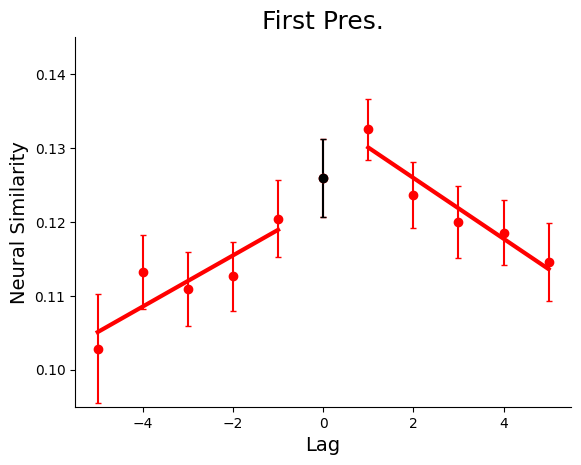

In [113]:
from numpy.polynomial.polynomial import polyfit

fix, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.errorbar(range(-5, 6), np.nanmean(RSA_first, axis = 0), yerr= ErrFirst, fmt="o", color="red", capsize = 2)
# plt.errorbar(range(-5, 6), np.nanmean(RSA_second, axis = 0), yerr= ErrSecond, fmt="o", color="dodgerblue", capsize = 2)
plt.errorbar(0, np.nanmean(RSA_first, axis = 0)[5], yerr= ErrFirst[5], fmt="o", color='k', capsize = 2)
# plt.legend(['First Pres.','Second Pres.'], frameon = False)

First_negs = np.nanmean(RSA_first, axis = 0)[0:5]
First_pos = np.nanmean(RSA_first, axis = 0)[6:]
b, m = polyfit( range(0,5), First_negs ,1)
plt.plot(range(-5, 0), b + m * range(0,5), '-', color = 'red', linewidth = 3)

b, m = polyfit( range(0,5), First_pos ,1)
plt.plot(range(1, 6), b + m * range(0, 5), '-', color = 'red', linewidth = 3)




# Second_negs = np.nanmean(RSA_second, axis = 0)[0:6]
# Second_pos = np.nanmean(RSA_second, axis = 0)[5:]
# b, m = polyfit( range(0,6), Second_negs ,1)
# plt.plot(range(-5, 1), b + m * range(0,6), '-', color = 'dodgerblue', linewidth = 3)
# b, m = polyfit( range(0,6), Second_pos ,1)
# plt.plot(range(0, 6), b + m * range(0, 6), '-', color = 'dodgerblue', linewidth = 3)

plt.ylim( .095, 0.145)
plt.title('First Pres.', fontsize = 18)
plt.xlabel('Lag', fontsize=14)
plt.ylabel('Neural Similarity', fontsize=14);

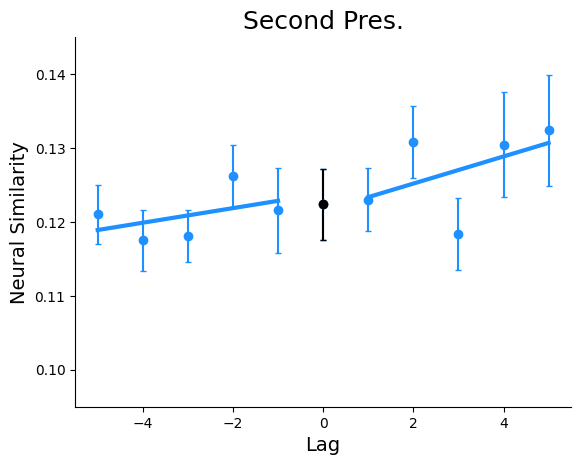

In [142]:
from numpy.polynomial.polynomial import polyfit

fix, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.errorbar(range(-5, 6), np.nanmean(RSA_first, axis = 0), yerr= ErrFirst, fmt="o", color="red", capsize = 2)
plt.errorbar(range(-5, 6), np.nanmean(RSA_second, axis = 0), yerr= ErrSecond, fmt="o", color="dodgerblue", capsize = 2)
plt.errorbar(0, np.nanmean(RSA_second, axis = 0)[5], yerr= ErrSecond[5], fmt="o", color='k', capsize = 2)
# plt.legend(['First Pres.','Second Pres.'], frameon = False)

# First_negs = np.nanmean(RSA_first, axis = 0)[0:6]
# First_pos = np.nanmean(RSA_first, axis = 0)[5:]
# b, m = polyfit( range(0,6), First_negs ,1)
# plt.plot(range(-5, 1), b + m * range(0,6), '-', color = 'red', linewidth = 3)

# b, m = polyfit( range(0,6), First_pos ,1)
# plt.plot(range(0, 6), b + m * range(0, 6), '-', color = 'red', linewidth = 3)




Second_negs = np.nanmean(RSA_second, axis = 0)[0:5]
Second_pos = np.nanmean(RSA_second, axis = 0)[6:]
b, m = polyfit( range(0,5), Second_negs ,1)
plt.plot(range(-5, 0), b + m * range(0,5), '-', color = 'dodgerblue', linewidth = 3)
b, m = polyfit( range(0,5), Second_pos ,1)
plt.plot(range(1, 6), b + m * range(0, 5), '-', color = 'dodgerblue', linewidth = 3)

plt.ylim( .095, 0.145)
plt.title('Second Pres.', fontsize = 18)
plt.xlabel('Lag', fontsize=14)
plt.ylabel('Neural Similarity', fontsize=14);


Get slopes over positive and negative lags

In [18]:
from scipy.stats import linregress, ttest_1samp

    
    
first_pos_slope = []
first_neg_slope = []
for i in range(len(RSA_first)):
    negs = RSA_first[i][0:5]
    pos = RSA_first[i][6:]
    res_pos = linregress(range(0, 5), pos)
    res_neg = linregress(range(0, 5), negs)
    first_pos_slope.append(res_pos.slope)
    first_neg_slope.append(res_neg.slope)
    
second_pos_slope = []
second_neg_slope = []
for i in range(len(RSA_second)):
    negs = RSA_second[i][0:5]
    pos = RSA_second[i][6:]
    res_pos = linregress(range(0, 5), pos)
    res_neg = linregress(range(0, 5), negs)
    second_pos_slope.append(res_pos.slope)
    second_neg_slope.append(res_neg.slope)
    

    
# sing_pos_slope = []
# sing_neg_slope = []
# for i in range(len(RSA_sing)):
#     negs = [RSA_sing[i][0], RSA_sing[i][4]]
#     pos = RSA_sing[i][6:]
#     res_pos = linregress(range(0, 5), pos)
#     res_neg = linregress([0, 4], negs)
#     sing_pos_slope.append(res_pos.slope)
#     sing_neg_slope.append(res_neg.slope)
    
    
    

Compare RSAs at absolute lags 1 and 3-5

In [13]:
sing_neg1 = []
sing_neg35= []
sing_pos1 = []
sing_pos35= []
for i in range(len(RSA_sing)):
    sing_neg1 = np.append(sing_neg1, RSA_sing[i][4])
    sing_neg35 = np.append(sing_neg35, np.mean(RSA_sing[i][0:3]))
    sing_pos1 = np.append(sing_pos1, RSA_sing[i][6])
    sing_pos35 = np.append(sing_pos35, np.mean(RSA_sing[i][8:]))
ttest_singpos = ttest_rel(sing_pos1, sing_pos35, alternative = 'greater')
ttest_singneg = ttest_rel(sing_neg1, sing_neg35, alternative = 'greater')
    
first_neg1 = []
first_neg35= []
first_pos1 = []
first_pos35= []
for i in range(len(RSA_first)):
    first_neg1 = np.append(first_neg1, RSA_first[i][4])
    first_neg35 = np.append(first_neg35, np.mean(RSA_first[i][0:3]))
    first_pos1 = np.append(first_pos1, RSA_first[i][6])
    first_pos35 = np.append(first_pos35, np.mean(RSA_first[i][8:]))
ttest_firstpos = ttest_rel(first_pos1, first_pos35, alternative = 'greater')
ttest_firstneg = ttest_rel(first_neg1, first_neg35, alternative = 'greater')
    
second_neg1 = []
second_neg35= []
second_pos1 = []
second_pos35= []
for i in range(len(RSA_second)):
    second_neg1 = np.append(second_neg1, RSA_second[i][4])
    second_neg35 = np.append(second_neg35, np.mean(RSA_second[i][0:3]))
    second_pos1 = np.append(second_pos1, RSA_second[i][6])
    second_pos35 = np.append(second_pos35, np.mean(RSA_second[i][8:]))
ttest_secondpos = ttest_rel(second_pos1, second_pos35, alternative = 'greater')
ttest_secondneg = ttest_rel(second_neg1, second_neg35, alternative = 'greater')

second_negdiff = second_neg1 - second_neg35
first_negdiff = first_neg1 - first_neg35
second_posdiff = second_pos1 - second_pos35
first_posdiff = first_pos1 - first_pos35
    